# Clustering Demo on 20 Newsgroups

This notebook will showcase a demo for how our clustering system works behind the scenes. A potential use case can then be seen in our web app demo, for which the process used to generate the data is nearly identical. We will go into a bit more detail on our pipeline here, but the more technical details can be found in our Project Report.

In [19]:
import re
import numpy as np
import matplotlib.pyplot as plt

from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, GPT2LMHeadModel

from sklearn.datasets import fetch_20newsgroups
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from ctfidf import ClassTfidfTransformer
import hdbscan


## Fetch news dataset

The initial idea behind this project is to cluster notes based on their content, which could for example be useful in note-taking apps like Notion or Obsidian. Due to the lack of available datasets, this demo will use a news dataset instead, which we find to be similar enough to notes for this purpose (small to medium length, with texts about a variety of recognizable topics like science or sports).

In [20]:
newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
idxs = [ i for i in range(len(newsgroups_train.data)) if len(newsgroups_train.data[i]) > 20 ]
newsgroups_train.data = [ newsgroups_train.data[i] for i in idxs ]
newsgroups_train.target = [ newsgroups_train.target[i] for i in idxs ]

In [21]:
print("Train data size: ", len(newsgroups_train.data))

print("Average train data length: ", np.mean([len(x.split()) for x in newsgroups_train.data]))

print("Train data labels: ", newsgroups_train.target_names)
print("Number of train data labels: ", len(newsgroups_train.target_names))

print(f"Example:\n[{newsgroups_train.target_names[newsgroups_train.target[0]]}] ", newsgroups_train.data[0])

Train data size:  10955
Average train data length:  191.90652670013694
Train data labels:  ['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']
Number of train data labels:  20
Example:
[rec.autos]  I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car,

## Generate sentence embeddings

We use the [SentenceBERT](https://sbert.net/index.html) project implementation of a Sentence Transformer to generate sentence embeddings. We tested a variety of different models from their collection, which all seem to yield similar results. The embedding is a 384-dimensional vector for every article.

In [22]:
model = SentenceTransformer('all-mpnet-base-v2')
train_embeddings = model.encode(newsgroups_train.data, show_progress_bar=True)
train_embeddings.shape

Batches:   0%|          | 0/343 [00:00<?, ?it/s]

(10955, 768)

## Cluster the embeddings

We then use a simple implementation of KMeans to cluster the embeddings together, which could be useful for grouping similar notes together. The number of clusters is set to 20, in this case, since we know the dataset had 20 categories. On our web demo we implemented a variable number of clusters, which acts as a different "zoom level" into the dataset.

In [23]:
num_clusters = 20
kmeans = KMeans(n_clusters=num_clusters, random_state=0, n_init='auto').fit(train_embeddings)
agg = AgglomerativeClustering(n_clusters=num_clusters, metric='euclidean', linkage='ward').fit(train_embeddings)
spectral = SpectralClustering(n_clusters=num_clusters, affinity='nearest_neighbors').fit(train_embeddings)

# Clustering algorithm of choice to use in later steps for visualization
clustering = kmeans

We also attempted to use HDBSCAN clustering, but decided against including it in later tests. The results are really sensible to hyperparameter tuning, which makes it hard to use in a real scenario, where the dataset of notes varies between the users. While the number of clusters in KMeans, for example, is very easily customizable by actual users (since it's easy to understand), we feel like HDBSCAN is not as intuitive. We also couldn't even get good results on this dataset after tuning the parameters, as can be seen in the plots below.

In [24]:
hdb = hdbscan.HDBSCAN(min_cluster_size=100, min_samples=1, cluster_selection_epsilon=0.5).fit(train_embeddings)

## Create the graph using tSNE

We perform dimensionality reduction on the embeddings with t-SNE to be able to plot them. We plot the three different clustering algorithms we tried, and compare them to the ground truth labels.

In [25]:
tsne = TSNE(n_components=2, n_iter=1000, n_iter_without_progress=200, perplexity=35)
print(train_embeddings.shape)
tsne_embeddings = tsne.fit_transform(train_embeddings)

(10955, 768)


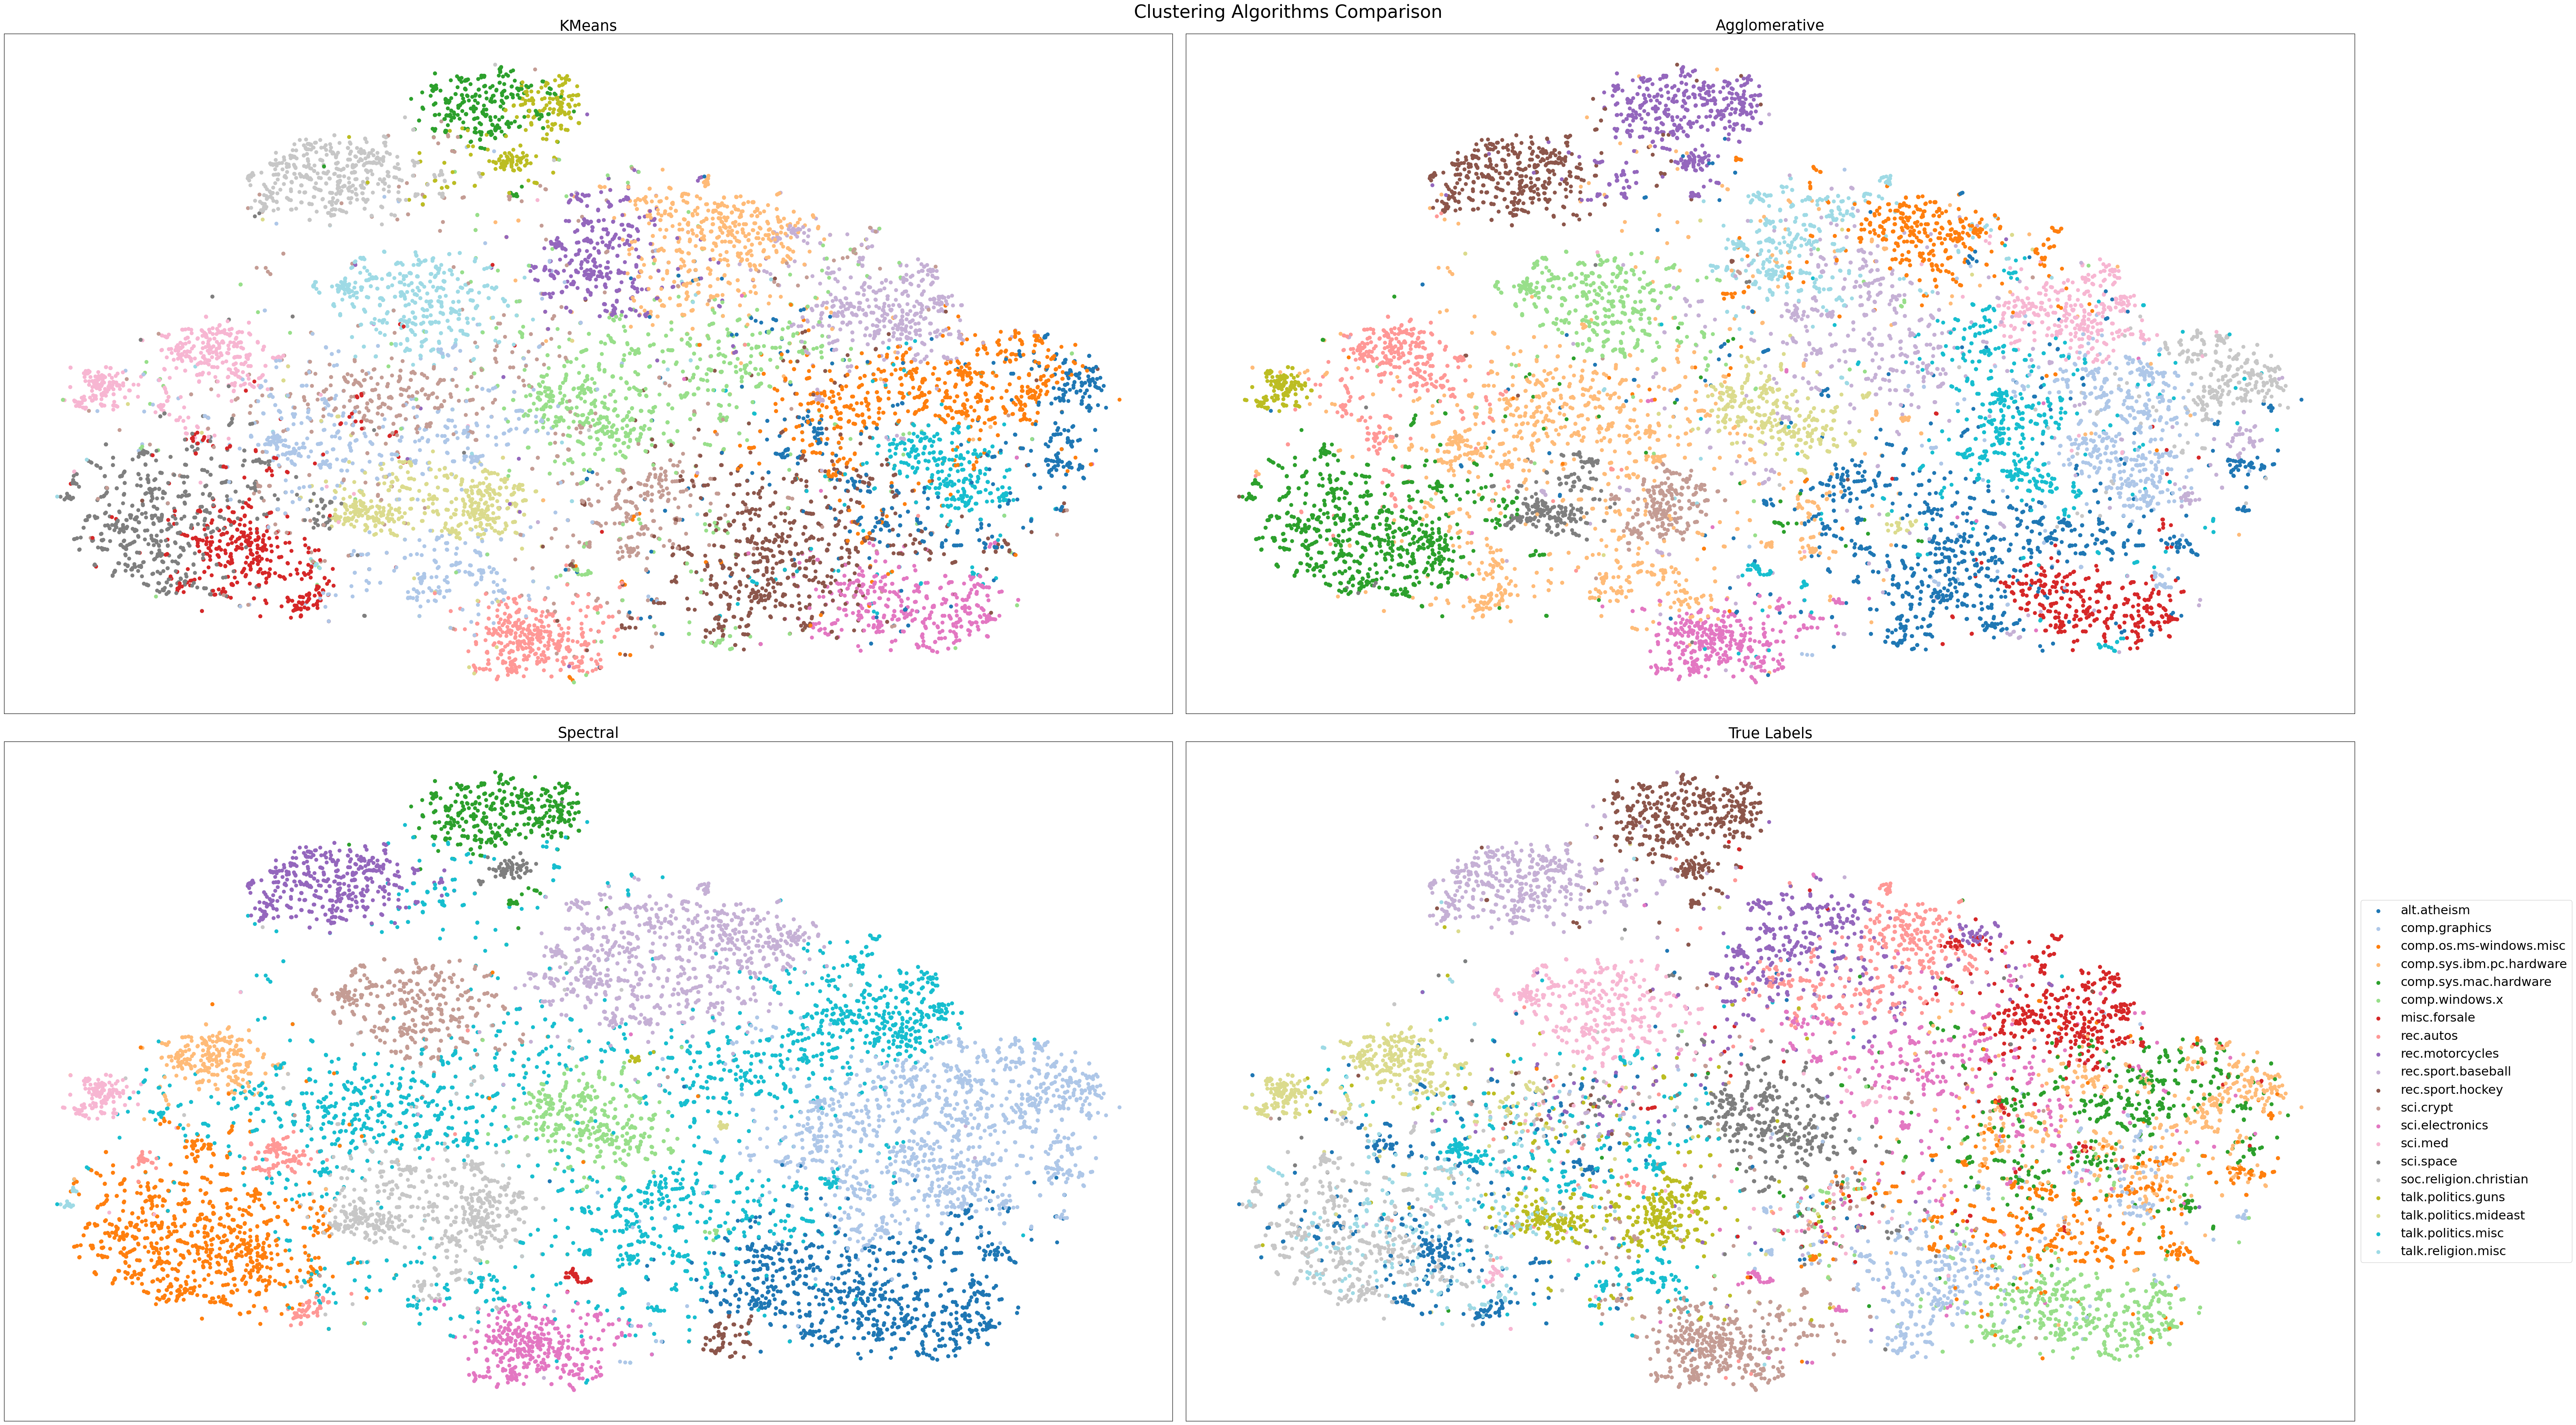

In [37]:
import matplotlib.pyplot as plt

clustering_algorithms = [    
    (kmeans.labels_, "KMeans"),     
    (agg.labels_, "Agglomerative"),     
    (spectral.labels_, "Spectral"),     
    (newsgroups_train.target, "True Labels")
]

fig, axs = plt.subplots(2, 2, figsize=(16*4, 9*4))
plt.rcParams.update({'font.size': 22})
axs = axs.flatten()

for i, (labels, title) in enumerate(clustering_algorithms):
    axs[i].scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], c=labels, cmap='tab20')
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i].set_title(title)

handles = [plt.scatter([],[],color=plt.cm.tab20(i/20), label=newsgroups_train.target_names[i]) for i in range(20)]
axs[-1].legend(handles=handles, loc='center left', bbox_to_anchor=(1, 0.5))

fig.suptitle("Clustering Algorithms Comparison", fontsize=32)
plt.tight_layout()

plt.rcParams.update({'font.size': 10})


Text(0.5, 1.0, 'HDBSCAN Clustering')

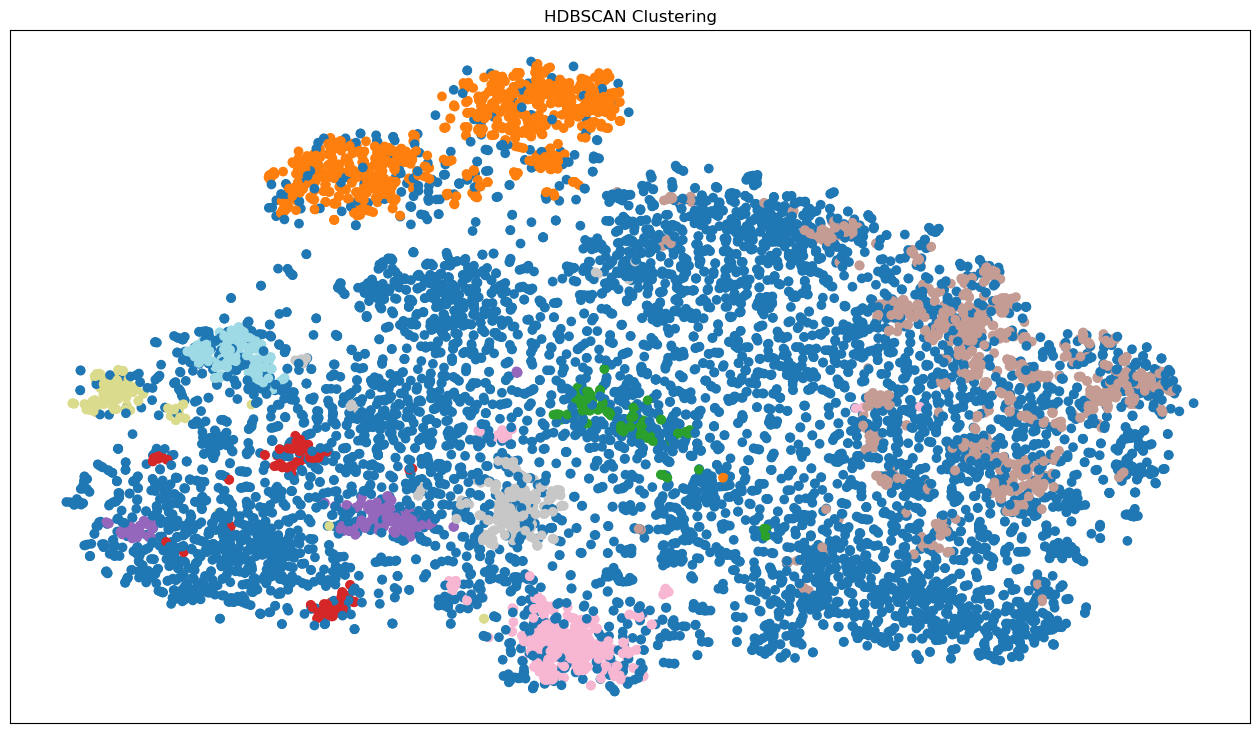

In [27]:
plt.figure(figsize=(16, 9))
plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], c=hdb.labels_, cmap='tab20')
plt.xticks([])
plt.yticks([])
plt.title("HDBSCAN Clustering")

We can see comparing the original labels (on the bottom) with the computed clusters (on the top) that the clustering algorithms do a pretty good job at grouping similar articles together, and finds clusters that are similar to the original dataset. This means that the embedding worked well enough to separate different articles and group similar ones together in the vector space. At first glance it looks like KMeans and Agglomerative Clustering do a better job than Spectral Clustering, which seems to find very big contiguous clusters that don't necessarily represent the more noisy dataset.

## Cluster labelling

To generate topics that can act as labels for our clusters, we use a class based tf-idf approach described in the BERTopic model. More details can be found in the Project Report. Note that we had to export the Class based TF-IDF model from the BERTopic library, since it is not available in the current version of Python (3.11).

In [28]:
def preprocess(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    return text

X = np.empty(num_clusters, dtype=object)
for i in range(num_clusters):
    X[i] = '\n'.join([newsgroups_train.data[j] for j in range(len(newsgroups_train.data)) if clustering.labels_[j] == i])

vectorizer = CountVectorizer(
    max_df=0.8,
    min_df=0.2,
    max_features=100000,
    stop_words="english",
    preprocessor=preprocess
)

ctfidf_model = ClassTfidfTransformer()

X = vectorizer.fit_transform(X)
X = ctfidf_model.fit_transform(X).todense()

features, tfidf_sort = np.array(vectorizer.get_feature_names_out()), np.argsort(X)

num_keywords = 20
top_n = features[tfidf_sort][:,-num_keywords:].tolist()
top_n = [kw[::-1] for kw in top_n]
keywords = {i: top_n[i] for i in range(len(top_n))}

print("Keywords for the clusters are:\n")
for n in range(len(keywords)):
    print("Cluster %s: %s" % (n, keywords[n]))

Keywords for the clusters are:

Cluster 0: ['disk', 'windows', 'dos', 'drives', 'bios', 'controller', 'floppy', 'sys', 'mouse', 'scsi', 'slave', 'rom', 'jumper', 'mb', 'boot', 'hardware', 'allocation', 'port', 'installed', 'ide']
Cluster 1: ['jobs', 'tax', 'gay', 'clinton', 'administration', 'congress', 'men', 'russia', 'drugs', 'secretary', 'water', 'health', 'rights', 'taxes', 'billion', 'funds', 'homosexual', 'homosexuals', 'freedom', 'federal']
Cluster 2: ['scsi', 'mb', 'mac', 'mhz', 'ram', 'pc', 'apple', 'ide', 'drives', 'cpu', 'controller', 'simms', 'isa', 'os', 'chip', 'disk', 'dx', 'chips', 'motherboard', 'port']
Cluster 3: ['cars', 'engine', 'bike', 'oil', 'miles', 'dealer', 'tires', 'bmw', 'ford', 'honda', 'bikes', 'toyota', 'brake', 'abs', 'rear', 'saturn', 'fuel', 'insurance', 'gas', 'buying']
Cluster 4: ['hockey', 'season', 'players', 'league', 'teams', 'player', 'flyers', 'det', 'ice', 'pit', 'draft', 'bos', 'tor', 'chi', 'que', 'coach', 'rangers', 'buf', 'min', 'ott']
Cl

## Obtaining a 1-word summary of the keywords
This isn't very reliable to we didn't end up including it in the Project Report, but the basic idea is to use the keywords to generate a 1-word summary of the cluster by using GPT2. This sometimes works pretty well, but more often fails spectacularly or returns an empty string, but it's a fun idea to play around with. This could hypothetically be improved with a better model, such as GPT3.

In [29]:
tokenizer = AutoTokenizer.from_pretrained('gpt2-large')
tokenizer.pad_token = tokenizer.eos_token

if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})

model = GPT2LMHeadModel.from_pretrained('gpt2-large')

for i in range(len(keywords)):

    query = f"A single word to define the topic given by the keywords [{', '.join(keywords[i])}] is: "
    inputs = tokenizer(query, return_tensors='pt', padding=True, truncation=True, max_length=50)
    outputs = model.generate(inputs.input_ids, attention_mask=inputs.attention_mask, max_length=60, 
                             pad_token_id=tokenizer.pad_token_id, do_sample=False)
    label = tokenizer.decode(outputs[0], skip_special_tokens=True)

    print(f"Cluster {i}: {label[len(query):]}")


Cluster 0: sk drive controller, disk
Cluster 1: y,
Cluster 2: 
Cluster 3: 
Cluster 4: -bruins,
Cluster 5:  station, space shuttle, space
Cluster 6: tive, truth
Cluster 7: ncryption, encryption
Cluster 8:  bike, bike, bike,
Cluster 9: ter2, h
Cluster 10: 
Cluster 11: 
Cluster 12: 
Cluster 13: 
Cluster 14: 
Cluster 15: ts,
Cluster 16: 
Cluster 17: eapons ban, assault weapons ban
Cluster 18: 
Cluster 19: r, cancer, cancer,


## Compare the results
In the plots below, we compare the labels on the computed clusters (here represented by the first two words in the topic) with the ground truth labels, to see if they match up. In general, they seem to almost perfectly correlate with the original labels, which is a good sign that the clustering worked well. If some labels seem a bit off, it's a good idea to check if the other keywords in the topic may be more relevant to the cluster, since we're only arbitrarily using the first two for ease of visualization. Some topics also make little sense (like Cluster 11), which is mostly full of tech abbreviations.

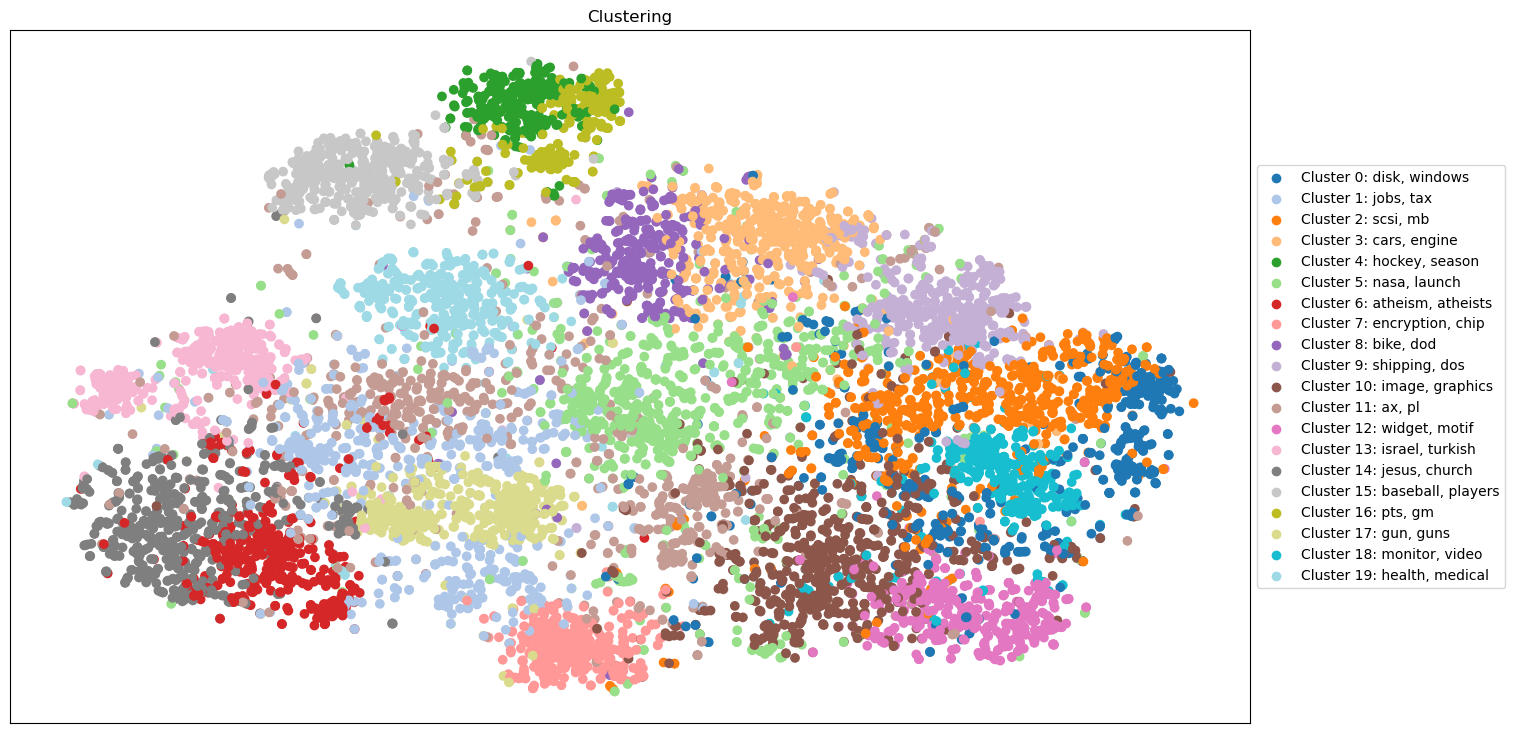

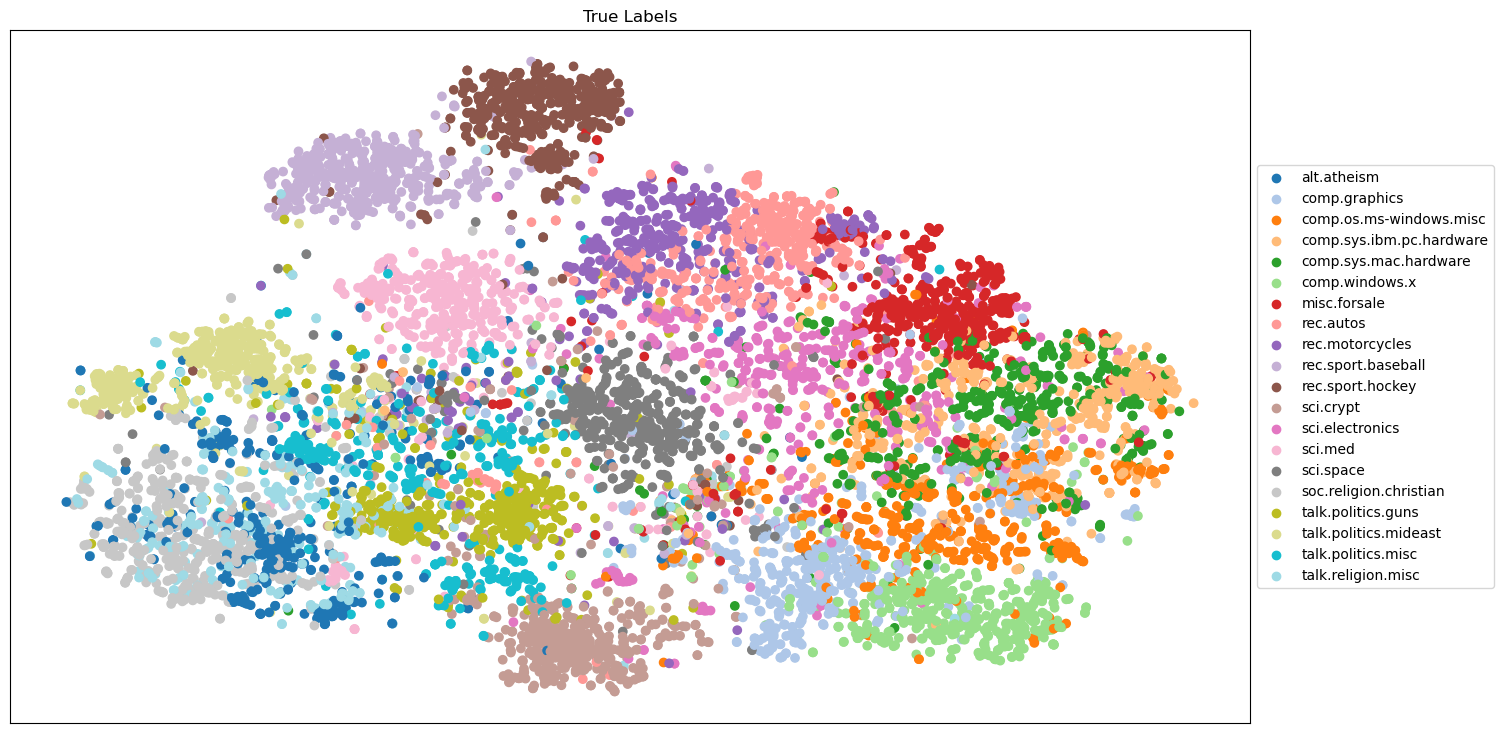

In [33]:
plt.figure(figsize=(16, 9))
plt.title("Clustering")
plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], c=clustering.labels_, cmap='tab20')
plt.xticks([])
plt.yticks([])
plt.legend(handles=[plt.scatter([],[],color=plt.cm.tab20(i/20), label=f"Cluster {i}: {keywords[i][0]}, {keywords[i][1]}") for i in range(20)], loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig("clustering.png")
plt.show()

plt.figure(figsize=(16, 9))
plt.title("True Labels")
plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], c=newsgroups_train.target, cmap='tab20')
plt.xticks([])
plt.yticks([])
plt.legend(handles=[plt.scatter([],[],color=plt.cm.tab20(i/20), label=newsgroups_train.target_names[i]) for i in range(20)], loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig("true_labels.png")
plt.show()

## Clustering Evaluation

We can also evaluate the clustering algorithm by comparing the original labels with the computed clusters. Both the completeness and homogeneity scores are around 0.5 ot 50%, which is reasonable for this dataset. The V-measure is a combination of both, and is also around 50%. This indicates that in general, around half of the articles in a cluster are from the same original label, and that half of the articles in a label are in the same cluster.

Spectral clustering seems to have a higher completeness, but a visual inspection shows that (at least in our opinion) the clusters are not as good as the ones generated by Agglomerative Clustering. This may be an artifact of the very big cluster generated by Spectral Clustering, which make it so that some labels are all in the same cluster (the big one) increasing the completeness score.

The Fowlkes-Mallows score is a measure of similarity between two clusterings which is theoretically more robust to noise, which indicates that KMeans is the best approach, corroborating our visual inspection. The eye test also made us think that Agglomerative Clustering could be a good alternative (and it is with other models, such as the simpler "Mini" variant), but the Fowlkes-Mallows score and V-measgure are lower than KMeans, which is why we chose to use KMeans in the end for this example.

In [31]:
from sklearn.metrics import homogeneity_completeness_v_measure, fowlkes_mallows_score

print("Homogeneity, Completeness, V-measure for KMeans: ", homogeneity_completeness_v_measure(newsgroups_train.target, kmeans.labels_))
print("Homogeneity, Completeness, V-measure for Agglomerative: ", homogeneity_completeness_v_measure(newsgroups_train.target, agg.labels_))
print("Homogeneity, Completeness, V-measure for Spectral: ", homogeneity_completeness_v_measure(newsgroups_train.target, spectral.labels_))

print("Fowlkes-Mallows score for KMeans: ", fowlkes_mallows_score(newsgroups_train.target, kmeans.labels_))
print("Fowlkes-Mallows score for Agglomerative: ", fowlkes_mallows_score(newsgroups_train.target, agg.labels_))
print("Fowlkes-Mallows score for Spectral: ", fowlkes_mallows_score(newsgroups_train.target, spectral.labels_))

Homogeneity, Completeness, V-measure for KMeans:  (0.5806314536262105, 0.5891594430763717, 0.5848643630503766)
Homogeneity, Completeness, V-measure for Agglomerative:  (0.5395117088665724, 0.562182808026735, 0.5506139910893016)
Homogeneity, Completeness, V-measure for Spectral:  (0.5459630533367066, 0.6606538448045376, 0.597857681031578)
Fowlkes-Mallows score for KMeans:  0.43760850163867654
Fowlkes-Mallows score for Agglomerative:  0.3833505996930551
Fowlkes-Mallows score for Spectral:  0.4016838573373356
